In [13]:
import torchvision
from torch import nn,utils
import torch.optim as optim
#from dataset_builder import *
#from model_train_val import *

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
import torch
import matplotlib.pyplot as plt   
import time
import copy
from dataset_builder import *
from PIL import Image, ImageFile
from torch.autograd import Variable
from torchvision import transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True
from IPython.display import display, Markdown

def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, checkpoint_path, num_epochs=25, device = "cpu"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        epoch_loss = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        },checkpoint_path+"/"+str(epoch)+".pt")
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(class_names, dataloaders, model, num_images=6, device = "cpu"):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def pred_image(model,img_path,class_names,transform_pipeline,show_image=False,device="cpu"):
    image = Image.open(img_path)

    if(show_image):
        display(image)

    image_transformed = transform_pipeline(image).to(device)
    image_transformed = image_transformed.unsqueeze(0)
    image_transformed = Variable(image_transformed)

    prediction = model(image_transformed.float())  # Returns a Tensor of shape (batch, num class labels)
    predicted_idx = prediction.data.cpu().numpy().argmax() # Our prediction will be the index of the class label with the largest value.
    probability = round(float(prediction.data.cpu().numpy().max()),1)

    print(f"Predicted Index : {predicted_idx}, Class : {class_names[predicted_idx]}, Confidence Level : {probability}%")

In [20]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

(all,all_dataSets,all_dataLoader) = generate_dataset('./data_dim',transform,0.3)

class_names = all.classes
all_dataset_sizes = len(all)
num_classes = len(class_names)

In [21]:
inputs, classes = next(iter(all_dataLoader['train']))
out = torchvision.utils.make_grid(inputs)

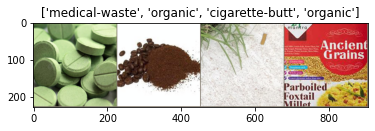

In [22]:
imshow(out,class_indices=classes,class_names=class_names)

In [1]:
#RESNET-18
# TODO paste and maybe modify relevant code to perform your own training
model_ft = torchvision.models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

checkpoint_path = "./checkpoints/resnet18"

model_resnet18_all = train_model(all_dataSets, all_dataLoader, model_ft, criterion, optimizer_conv,
                         exp_lr_scheduler, checkpoint_path, num_epochs=25, device=device)

'#RESNET-18\n# TODO paste and maybe modify relevant code to perform your own training\nmodel_ft = torchvision.models.resnet18(pretrained=True)\n\nnum_ftrs = model_ft.fc.in_features\nmodel_ft.fc = nn.Linear(num_ftrs, num_classes)\n\nmodel_ft = model_ft.to(device)\n\ncriterion = nn.CrossEntropyLoss()\n\n# Observe that only parameters of final layer are being optimized as\n# opposed to before.\noptimizer_conv = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)\n\n# Decay LR by a factor of 0.1 every 7 epochs\nexp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)\n\ncheckpoint_path = "./checkpoints/resnet18"\n\nmodel_resnet18_all = train_model(all_dataSets, all_dataLoader, model_ft, criterion, optimizer_conv,\n                         exp_lr_scheduler, checkpoint_path, num_epochs=25, device=device)\n'

In [26]:
torch.save(model_resnet18_all,'./models/resnet18.pt')

In [29]:
visualize_model(all.classes,all_dataLoader,model_resnet18_all,device=device)

'visualize_model(all.classes,all_dataLoader,model_resnet18_all,device=device)'

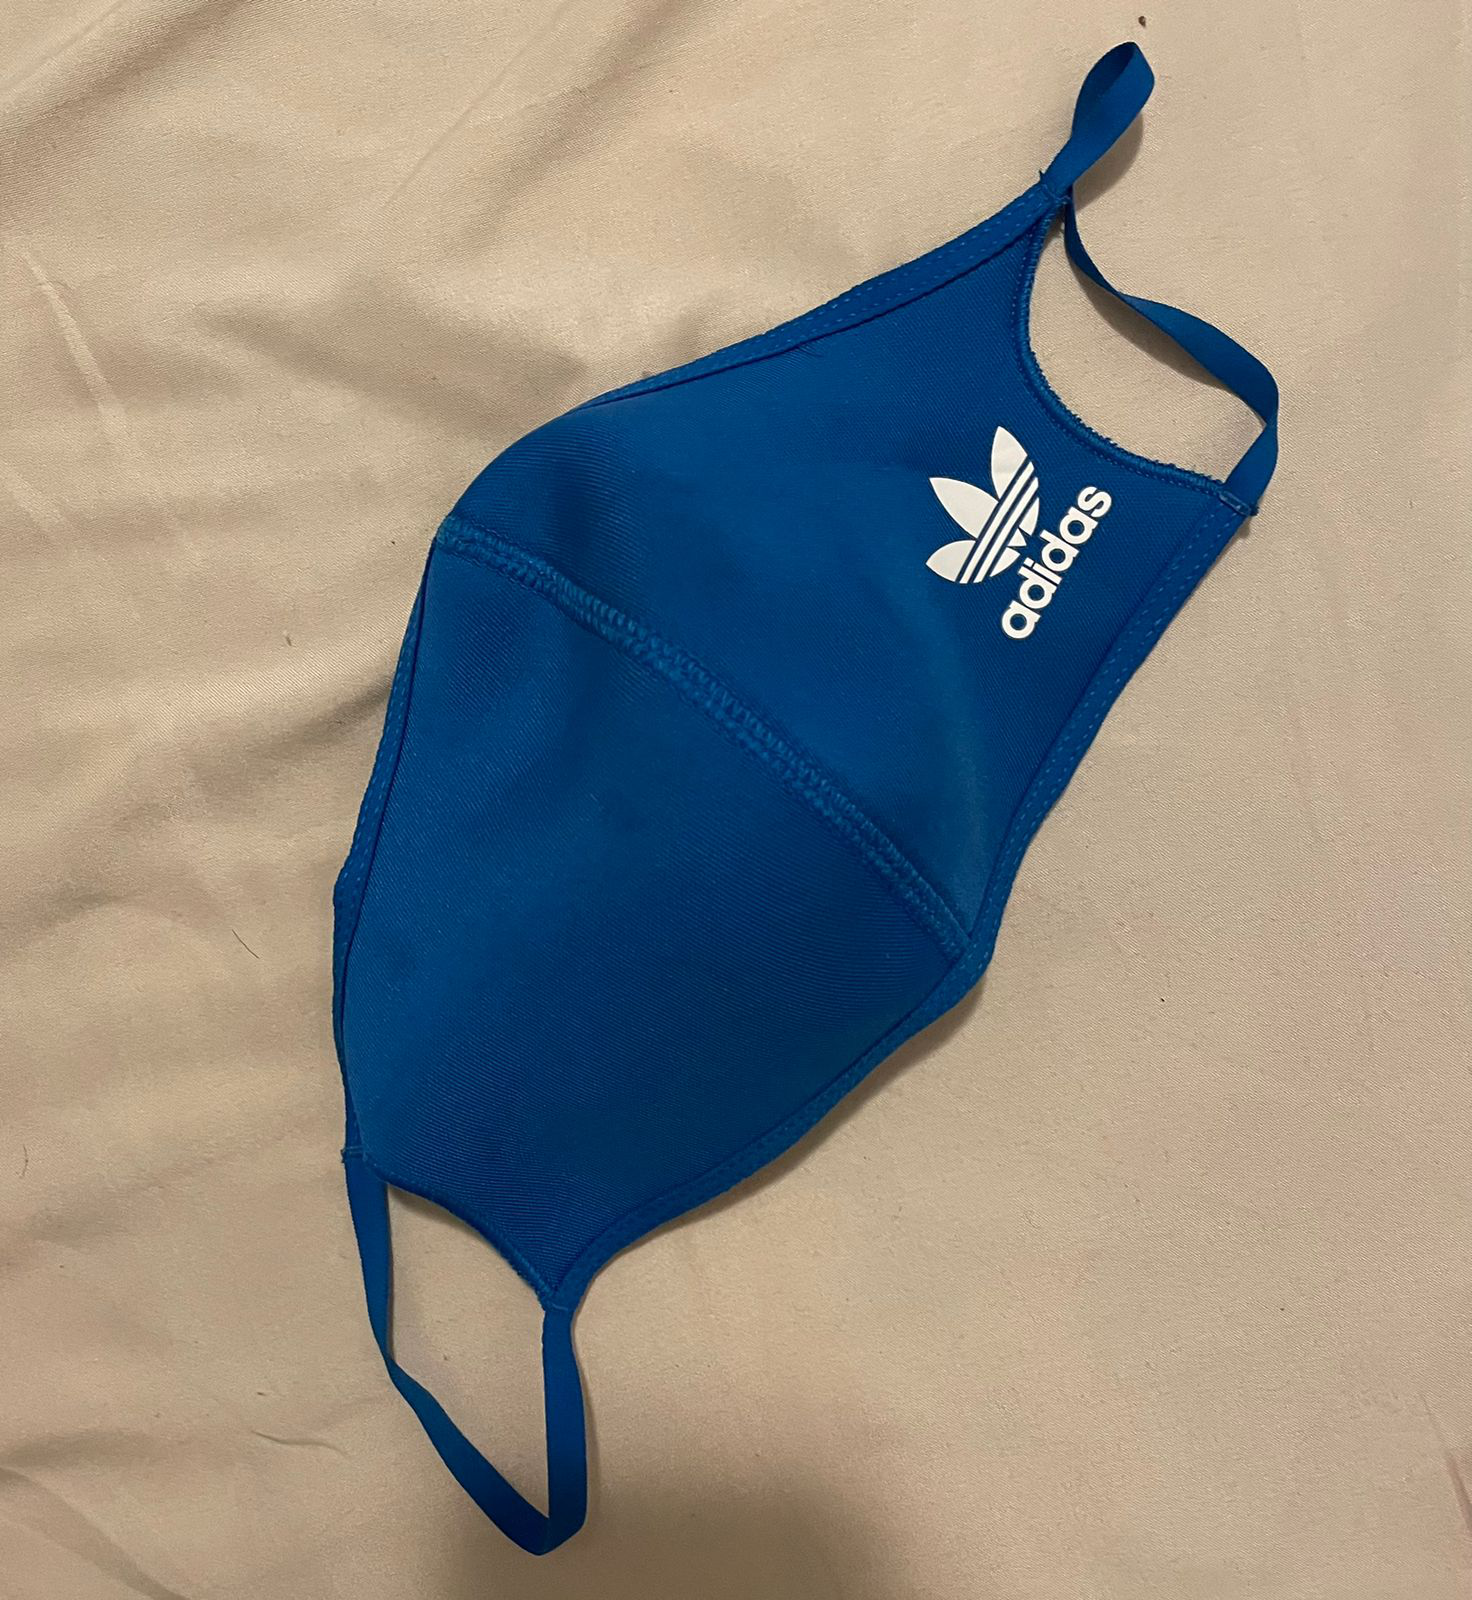

Predicted Index : 8, Class : face-masks, Confidence Level : 7.3%


In [28]:
min_img_size = 224

transform_pipeline = transforms.Compose([transforms.Resize(min_img_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])

pred_image(model_resnet18_all,"adidas_mask.jpg",class_names,transform_pipeline, show_image = True,device = device)